In [ ]:
# GIẢI PHÁP CUỐI CÙNG: Ưu tiên cho các thư viện chính hoạt động.
# Bỏ qua các cảnh báo của Colab vì code của chúng ta không dùng đến chúng.
# Thêm openpyxl để đảm bảo to_excel hoạt động trơn tru.
!pip install pandas-ta xlsxwriter openpyxl -q

# >>> BẠN SẼ THẤY CẢNH BÁO MÀU ĐỎ SAU KHI CELL NÀY CHẠY, HÃY BỎ QUA NÓ <<<
# Miễn là nó không báo lỗi "ERROR: ResolutionImpossible" là được.
# Sau khi chạy xong, hãy khởi động lại phiên chạy (Runtime > Restart Session) rồi chạy lại TOÀN BỘ code một lần nữa.

from pathlib import Path
import pandas as pd
import numpy as np
import re
import os
import pandas_ta as ta

# ======= CONFIGURATION =======
STOCK_DATA_FOLDER = Path("Data")
EXTERNAL_DATA_FOLDER = Path("ExternalData")
BENCHMARK_FILE = 'VNI_020114_141125.csv'
OUTPUT_XLSX_PATH = Path("Processed_VN30_FullDataSet_9_Indicators.xlsx")

# Original and new English column names for stock data
COLS_TO_EXTRACT_STOCK = ['Lần cuối', 'Mở', 'Cao', 'Thấp', 'KL', '% Thay đổi']
COLS_ENGLISH_NAMES = ['Close', 'Open', 'High', 'Low', 'Volume', 'Change_Pct']

# ---------- Data Cleaning Helpers (Giữ nguyên) ----------
def to_number(x):
    if pd.isna(x): return pd.NA
    s = str(x).strip().replace(',', '')
    try: return float(s)
    except: return pd.NA

def parse_percent(x):
    if pd.isna(x): return pd.NA
    s = str(x).strip().replace(',', '').replace('%', '').replace('−', '-')
    try: return float(s)
    except: return pd.NA

def parse_volume(x):
    if pd.isna(x): return pd.NA
    s = str(x).strip().replace(',', '').upper()
    if 'B' in s: return float(s.replace('B', '')) * 1e9
    if 'M' in s: return float(s.replace('M', '')) * 1e6
    if 'K' in s: return float(s.replace('K', '')) * 1e3
    try: return float(s)
    except: return pd.NA

def clean_and_rename_df(df, original_cols, new_names):
    df_cleaned = df.copy()
    rename_map = dict(zip(original_cols, new_names))
    if 'Lần cuối' in df_cleaned.columns: df_cleaned['Lần cuối'] = df_cleaned['Lần cuối'].apply(to_number)
    if 'Mở' in df_cleaned.columns: df_cleaned['Mở'] = df_cleaned['Mở'].apply(to_number)
    if 'Cao' in df_cleaned.columns: df_cleaned['Cao'] = df_cleaned['Cao'].apply(to_number)
    if 'Thấp' in df_cleaned.columns: df_cleaned['Thấp'] = df_cleaned['Thấp'].apply(to_number)
    if 'KL' in df_cleaned.columns: df_cleaned['KL'] = df_cleaned['KL'].apply(parse_volume)
    if '% Thay đổi' in df_cleaned.columns: df_cleaned['% Thay đổi'] = df_cleaned['% Thay đổi'].apply(parse_percent)
    df_cleaned = df_cleaned.rename(columns=rename_map)
    return df_cleaned

def read_and_standardize(path, is_external=False):
    try: df = pd.read_csv(path, encoding='utf-8-sig')
    except Exception: df = pd.read_csv(path, encoding='latin-1')
    if 'Ngày' not in df.columns: return None
    df = df.rename(columns={'Ngày': 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df = df.dropna(subset=['Date'])
    if is_external:
        value_col_name = next((col for col in ['Giá', 'Lần cuối', 'Value'] if col in df.columns), None)
        if value_col_name:
            df = df[['Date', value_col_name]].rename(columns={value_col_name: 'Value'})
            df['Value'] = df['Value'].apply(to_number)
        else: return None
    else:
        keep_cols = ['Date'] + [c for c in COLS_TO_EXTRACT_STOCK if c in df.columns]
        df = df[keep_cols]
        df = clean_and_rename_df(df, COLS_TO_EXTRACT_STOCK, COLS_ENGLISH_NAMES)
    return df.sort_values('Date').reset_index(drop=True)

def add_prefix(df, prefix):
    return df.rename(columns={c: f'{prefix}_{c}' for c in df.columns if c != 'Date'})

# ---------- MAIN DATA ENGINEERING PIPELINE ----------
def create_full_dataset_with_9_indicators():
    # Thêm kiểm tra thư mục tồn tại và tạo nếu cần
    if not STOCK_DATA_FOLDER.exists():
        STOCK_DATA_FOLDER.mkdir()
        print(f"CRITICAL: Folder '{STOCK_DATA_FOLDER}' was not found and has been created.")
        print("Please upload your stock CSV files into this folder and run the script again.")
        return None

    benchmark_path = STOCK_DATA_FOLDER / BENCHMARK_FILE
    if not benchmark_path.exists():
        print(f"CRITICAL ERROR: Benchmark file '{BENCHMARK_FILE}' not found in folder '{STOCK_DATA_FOLDER}'.")
        return None

    df_benchmark = read_and_standardize(benchmark_path)
    if df_benchmark is None:
        print(f"CRITICAL ERROR: Benchmark file '{BENCHMARK_FILE}' could not be read properly. Aborting.")
        return None
    final_df = df_benchmark[['Date']].copy()

    print("--- Processing Stock Data and 9 Technical Indicators ---")

    # Lấy danh sách các file trong thư mục
    stock_files = [f for f in sorted(os.listdir(STOCK_DATA_FOLDER)) if f.lower().endswith('.csv')]
    if len(stock_files) <= 1: # Chỉ có file benchmark
        print("WARNING: No stock data files found in 'Data' folder besides the benchmark file.")

    for fname in stock_files:
        path = os.path.join(STOCK_DATA_FOLDER, fname)
        symbol = os.path.splitext(fname)[0].replace(' ', '_')

        df_stock = read_and_standardize(path)
        if df_stock is None: continue

        print(f"  Processing: {symbol}")

        try:
            df_stock.ta.rsi(length=14, append=True)
            df_stock.ta.macd(fast=12, slow=26, signal=9, append=True)
            df_stock.ta.sma(length=50, append=True)
            df_stock.ta.sma(length=200, append=True)
            df_stock.ta.ema(length=20, append=True)
            df_stock.ta.bbands(length=20, append=True)
            df_stock.ta.obv(append=True)
            df_stock.ta.adx(length=14, append=True)
            df_stock.ta.stoch(append=True)
            df_stock.ta.atr(length=14, append=True)
        except Exception as e:
            print(f"    --> WARNING: Could not calculate indicators for {symbol}. Maybe not enough data points. Skipping. Error: {e}")
            continue

        df_with_prefix = add_prefix(df_stock, symbol)
        final_df = final_df.merge(df_with_prefix, on='Date', how='left')

    print("\n--- Processing External Factor Data ---")
    if not os.path.exists(EXTERNAL_DATA_FOLDER):
        print(f"Warning: Folder '{EXTERNAL_DATA_FOLDER}' not found. Skipping external factors.")
    else:
        for fname in sorted(os.listdir(EXTERNAL_DATA_FOLDER)):
            if not fname.lower().endswith('.csv'): continue
            path = os.path.join(EXTERNAL_DATA_FOLDER, fname)
            factor_name = os.path.splitext(fname)[0].replace(' ', '_')

            print(f"  Processing: {factor_name}")
            df_external = read_and_standardize(path, is_external=True)
            if df_external is None: continue

            df_with_prefix = add_prefix(df_external, factor_name)
            final_df = final_df.merge(df_with_prefix, on='Date', how='left')

    print("\n--- Imputing missing values ---")
    final_df = final_df.set_index('Date')
    final_df = final_df.interpolate(method='time')
    final_df = final_df.ffill().bfill()
    final_df = final_df.reset_index()

    final_df.to_excel(OUTPUT_XLSX_PATH, index=False, engine='openpyxl')
    print(f"\n✅ SUCCESS: Full dataset with 9 indicators saved to '{OUTPUT_XLSX_PATH}'")

    return final_df

# Để chạy, bạn gọi hàm:
# create_full_dataset_with_9_indicators()

In [ ]:
# Chạy pipeline để tạo bộ dữ liệu
full_dataset = create_full_dataset_with_9_indicators()




--- Processing Stock Data and 9 Technical Indicators ---
  Processing: ACB
  Processing: BCM
  Processing: BID
  Processing: CTG
  Processing: DGC
  Processing: GAS
  Processing: HDB
  Processing: VNI_020114_141125

--- Processing External Factor Data ---

--- Imputing missing values ---

✅ SUCCESS: Full dataset with 9 indicators saved to 'Processed_VN30_FullDataSet_9_Indicators.xlsx'


In [ ]:
import pandas as pd
import numpy as np
import re
from pathlib import Path # Add this import

# Define BASE_DRIVE_PATH for output (assuming current working directory)
BASE_DRIVE_PATH = Path('./') # This needs to be defined

# ==============================================================================
# --- STEP 1: CREATE A WORKING COPY OF THE DATASET ---
# ==============================================================================
# We'll work on this copy to keep the original 'full_dataset' intact.
df_for_discretization = full_dataset.copy()


# ==============================================================================
# --- STEP 2: DEFINE GENERIC DISCRETIZATION RULES BY INDICATOR TYPE ---
# ==============================================================================
# This dictionary contains universal rules for different types of indicators.
# The code will automatically apply these rules to any column whose name contains the key.
# For example, the 'RSI' rule will apply to 'HPG_RSI_14', 'FPT_RSI_14', etc.

GENERIC_RULES = {
    # --- Trend & Price Change Indicators ---
    'Change_Pct': {
        'method': 'bins',
        'bins': [-float('inf'), -1.5, -0.5, 0.5, 1.5, float('inf')],
        'labels': ['Strong_Down', 'Down', 'Sideways', 'Up', 'Strong_Up']
    },

    # --- Momentum Oscillators ---
    'RSI_14': { # Be more specific to avoid matching other columns with "RSI"
        'method': 'bins',
        'bins': [-float('inf'), 30, 70, float('inf')],
        'labels': ['Oversold', 'Neutral', 'Overbought']
    },
    'STOCHk_14_3_3': { # Target the %K line
        'method': 'bins',
        'bins': [-float('inf'), 20, 80, float('inf')],
        'labels': ['Stoch_Oversold', 'Stoch_Neutral', 'Stoch_Overbought']
    },
    'STOCHd_14_3_3': { # NEW: Target the %D line (signal)
        'method': 'bins',
        'bins': [-float('inf'), 20, 80, float('inf')],
        'labels': ['Stoch_Signal_Oversold', 'Stoch_Signal_Neutral', 'Stoch_Signal_Overbought']
    },

    # --- Trend-Following Indicators ---
    'MACD_12_26_9': { # Main MACD line
        'method': 'bins',
        'bins': [-float('inf'), 0, float('inf')],
        'labels': ['MACD_Negative', 'MACD_Positive']
    },
    'MACDh_12_26_9': { # MACD Histogram
        'method': 'bins',
        'bins': [-float('inf'), 0, float('inf')],
        'labels': ['MACD_Momentum_Down', 'MACD_Momentum_Up']
    },

    # --- Volatility Indicators ---
    'BBP_20_2.0': { # Bollinger Bands %B
        'method': 'bins',
        'bins': [-float('inf'), 0, 0.5, 1, float('inf')],
        'labels': ['Below_Band', 'Lower_Half', 'Upper_Half', 'Above_Band']
    },
    'ATRr_14': { # Average True Range (Volatility)
        'method': 'quantiles',
        'q': [0, 0.33, 0.66, 1],
        'labels': ['Low_Volatility', 'Medium_Volatility', 'High_Volatility']
    },

    # --- Position vs. Moving Averages (MA) ---
    'SMA_50': { 'method': 'cross', 'cross_with': 'Close' },
    'SMA_200': { 'method': 'cross', 'cross_with': 'Close' },
    'EMA_20': { 'method': 'cross', 'cross_with': 'Close' }, # NEW: Added EMA_20 rule

    # --- Volume-Based Indicators ---
    'OBV': {
        'method': 'trend',
        'labels': ['OBV_Down', 'OBV_Neutral', 'OBV_Up']
    },
    'Volume': {
        'method': 'quantiles',
        'q': [0, 0.33, 0.66, 1],
        'labels': ['Low_Volume', 'Medium_Volume', 'High_Volume']
    },

    # --- Trend Strength Indicator ---
    'ADX_14': { # ADX
        'method': 'quantiles',
        'q': [0, 0.33, 0.66, 1],
        'labels': ['Weak_Trend', 'Moderate_Trend', 'Strong_Trend']
    },

    # --- Generic Rule for External Factors ---
    'Value': {
        'method': 'trend',
        'labels': ['Value_Down', 'Value_Neutral', 'Value_Up']
    }
}


# ==============================================================================
# --- STEP 3: FULLY AUTOMATIC AND DYNAMIC DISCRETIZATION FUNCTION ---
# ==============================================================================
def auto_discretize_dataframe(df, rules):
    """
    Automatically finds and discretizes all relevant columns in the dataframe based on the generic rules.
    It is flexible and handles any number of new datasets/prefixes automatically.
    """
    discretized_df = pd.DataFrame()
    discretized_df['Date'] = df['Date'] # Start with the Date column

    print("--- Automatically Discretizing All Found Columns ---")

    all_cols = df.columns.tolist()

    # A set to keep track of columns that have already been used for a 'cross' rule
    used_for_cross = set()

    for col in all_cols:
        if col == 'Date':
            continue

        applied_rule = False
        # Iterate through the rules to find a match in the column name
        for indicator_key, params in rules.items():
            if indicator_key in col:
                # --- APPLY RULES BASED ON THE SPECIFIED 'method' ---

                # Method 1: Binning with predefined thresholds
                if params.get('method') == 'bins':
                    new_col_name = f"{col}_State"
                    discretized_df[new_col_name] = pd.cut(df[col], bins=params['bins'], labels=params['labels'], right=False)
                    print(f"  > Applied rule '{indicator_key}' to '{col}' -> created '{new_col_name}'")
                    applied_rule = True
                    break

                # Method 2: Binning based on quantiles (e.g., top 33%, middle 33%, bottom 33%)
                elif params.get('method') == 'quantiles':
                    new_col_name = f"{col}_State"
                    try:
                        # Calculate actual quantile bins, handle potential duplicates
                        # Use 'linear' interpolation as it's the default for qcut
                        quantiles = df[col].quantile(params['q'], interpolation='linear')
                        unique_bins = sorted(quantiles.drop_duplicates().tolist()) # Ensure unique and sorted edges

                        # The number of actual bins will be one less than the number of unique edges
                        actual_num_bins_formed = len(unique_bins) - 1

                        if actual_num_bins_formed <= 0:
                            # If no meaningful bins can be formed (e.g., all values are same or NaN)
                            discretized_df[new_col_name] = 'No_Meaningful_Quantiles'
                            print(f"      - Fallback: '{col}' assigned 'No_Meaningful_Quantiles' due to insufficient unique values for quantiles.")
                        else:
                            # Adapt labels to the actual number of bins formed
                            adapted_labels = params['labels'][:actual_num_bins_formed]

                            # Use pd.cut with the determined unique bins and adapted labels
                            discretized_df[new_col_name] = pd.cut(df[col], bins=unique_bins, labels=adapted_labels, right=False)

                        print(f"  > Applied rule '{indicator_key}' to '{col}' -> created '{new_col_name}' (Quantile with {actual_num_bins_formed} bins)")
                        applied_rule = True
                        break # Important: stop after the first matching rule is found and applied
                    except Exception as e:
                        print(f"    - Error: Could not apply quantile rule to '{col}'. Skipping. Error: {e}")
                        # Assign NA for the column that failed and mark rule as applied to skip 'No rule found' msg
                        discretized_df[new_col_name] = pd.NA
                        applied_rule = True
                        break # Exit the inner loop for rules for this column

                # Method 3: Discretizing the day-over-day trend (Up, Down, Sideways)
                elif params.get('method') == 'trend':
                    new_col_name = f"{col}_Trend"
                    diff = df[col].diff()
                    discretized_df[new_col_name] = pd.cut(diff, bins=[-float('inf'), -1e-7, 1e-7, float('inf')], labels=params['labels'], right=False)
                    print(f"  > Applied rule '{indicator_key}' to '{col}' -> created '{new_col_name}'")
                    applied_rule = True
                    break

                # Method 4: Checking the position of one column relative to another (e.g., Close vs. SMA)
                elif params.get('method') == 'cross':
                    prefix = col.split(indicator_key)[0]
                    cross_col_name = f"{prefix}{params['cross_with']}"

                    if cross_col_name in df.columns:
                        new_col_name = f"{prefix}{params['cross_with']}_vs_{indicator_key}"
                        discretized_df[new_col_name] = np.where(df[cross_col_name] > df[col], 'Above', 'Below')
                        used_for_cross.add(cross_col_name) # Mark the 'Close' column as used for this purpose
                        print(f"  > Applied rule '{indicator_key}' to '{col}' -> created '{new_col_name}'")
                        applied_rule = True
                        break
                    else:
                        print(f"    - Warning: For rule '{indicator_key}', cross column '{cross_col_name}' was not found. Skipping this rule for '{col}'.")
                        continue # Continue to next rule for this column if cross_col not found

        if not applied_rule and col not in used_for_cross:
            # Only print info if no rule was applied and it wasn't a 'Close' column already handled by a cross rule
            print(f"  - Info: No specific rule found for '{col}'. It will be skipped.")

    # Drop any rows with missing values that resulted from calculations (like .diff() or initial indicator values)
    original_rows = len(discretized_df)
    discretized_df = discretized_df.dropna().reset_index(drop=True)
    print(f"\nRemoved {original_rows - len(discretized_df)} initial rows with missing values to ensure a clean dataset.")

    return discretized_df

# ==============================================================================
# --- STEP 4: EXECUTE THE PIPELINE AND DISPLAY THE RESULTS ---
# ==============================================================================
# Run the automatic and advanced discretization function
df_discretized_final = auto_discretize_dataframe(df_for_discretization, GENERIC_RULES)

# Display a sample of the results
if df_discretized_final is not None:
    print("\n--- Final Discretized Data Sample (first 5 rows): ---")
    print(df_discretized_final.head())

    print("\n--- Total Discretized Columns Created: ---")
    print(df_discretized_final.columns.tolist())
else:
    print("\nDiscretization process failed. Please check the logs for errors.")

# ==============================================================================
# --- STEP 5: EXPORT THE FINAL DISCRETIZED DATAFRAME TO EXCEL ---
# ==============================================================================

# Define the path for the output Excel file
# It will be saved in the same main project folder on your Google Drive
DISCRETIZED_OUTPUT_PATH = BASE_DRIVE_PATH / "Final_Discretized_Dataset.xlsx"

if 'df_discretized_final' in locals() and df_discretized_final is not None:
    try:
        print(f"\n--- Exporting the discretized data to Excel ---")
        print(f"File will be saved at: {DISCRETIZED_OUTPUT_PATH}")

        # Use the .to_excel() method to save the dataframe
        df_discretized_final.to_excel(
            DISCRETIZED_OUTPUT_PATH,
            index=False,          # Do not write dataframe index as a column
            engine='xlsxwriter'   # A good engine for writing Excel files
        )

        print(f"\n\u2705 SUCCESS: File '{DISCRETIZED_OUTPUT_PATH.name}' has been successfully saved to your Google Drive.")
        print("You can now open it to inspect the data.")

    except Exception as e:
        print(f"\n\u274c ERROR: An error occurred while saving the Excel file: {e}")
else:
    print("\nWarning: The 'df_discretized_final' dataframe does not exist or is empty. Cannot export to Excel.")
    print("Please make sure the previous cell (auto-discretization) ran successfully.")

--- Automatically Discretizing All Found Columns ---
  - Info: No specific rule found for 'ACB_Close'. It will be skipped.
  - Info: No specific rule found for 'ACB_Open'. It will be skipped.
  - Info: No specific rule found for 'ACB_High'. It will be skipped.
  - Info: No specific rule found for 'ACB_Low'. It will be skipped.
  > Applied rule 'Volume' to 'ACB_Volume' -> created 'ACB_Volume_State' (Quantile with 3 bins)
  > Applied rule 'Change_Pct' to 'ACB_Change_Pct' -> created 'ACB_Change_Pct_State'
  > Applied rule 'RSI_14' to 'ACB_RSI_14' -> created 'ACB_RSI_14_State'
  > Applied rule 'MACD_12_26_9' to 'ACB_MACD_12_26_9' -> created 'ACB_MACD_12_26_9_State'
  > Applied rule 'MACDh_12_26_9' to 'ACB_MACDh_12_26_9' -> created 'ACB_MACDh_12_26_9_State'
  - Info: No specific rule found for 'ACB_MACDs_12_26_9'. It will be skipped.
  > Applied rule 'SMA_50' to 'ACB_SMA_50' -> created 'ACB_Close_vs_SMA_50'
  > Applied rule 'SMA_200' to 'ACB_SMA_200' -> created 'ACB_Close_vs_SMA_200'
  > Ap

In [ ]:
# ==============================================================================
# --- STEP 6: CREATE TIME-LAGGED DATA FOR DYNAMIC BAYESIAN NETWORK (DBN) ---
# ==============================================================================

def create_dbn_timeseries_data(df):
    """
    Transforms the discretized time series data into a format suitable for pgmpy's DBN.
    This structure allows the model to learn dependencies from t-1 to t.

    Args:
        df (pd.DataFrame): The discretized dataframe.

    Returns:
        pd.DataFrame: A new dataframe where each row contains data for two consecutive time steps.
    """
    if df is None or df.empty:
        print("Input dataframe is empty. Cannot create DBN data.")
        return None

    # Get the names of all state variables (all columns except 'Date')
    variable_names = [col for col in df.columns if col != 'Date']

    # Create a copy to work on
    df_lagged = df[variable_names].copy()

    print(f"--- Creating time-lagged data from {len(variable_names)} variables ---")

    # For DBNs in pgmpy, we structure columns as tuples: ('Variable', time_slice)
    # We will create two time slices: 0 (for t-1) and 1 (for t)

    # Create columns for the next time step (time_slice = 1) by shifting the data up by one row
    for var in variable_names:
        df_lagged[(var, 1)] = df_lagged[var].shift(-1)

    # Rename the original columns to represent the current time step (time_slice = 0)
    df_lagged = df_lagged.rename(columns={var: (var, 0) for var in variable_names})

    # The last row will now have NaN values in the (var, 1) columns because there is no "next day" for it.
    # We drop this last row to ensure the dataset is clean.
    df_lagged = df_lagged.dropna()

    # Reorder columns to a more logical sequence: all t-1 variables first, then all t variables
    time_0_cols = sorted([col for col in df_lagged.columns if col[1] == 0])
    time_1_cols = sorted([col for col in df_lagged.columns if col[1] == 1])

    final_dbn_df = df_lagged[time_0_cols + time_1_cols]

    print(f"Successfully created DBN training data with {len(final_dbn_df)} samples.")

    return final_dbn_df

# ==============================================================================
# --- EXECUTE AND DISPLAY ---
# ==============================================================================

# Ensure 'df_discretized_final' exists from the previous cell
if 'df_discretized_final' in locals() and df_discretized_final is not None:
    # Create the final dataframe ready for DBN model training
    df_for_dbn_training = create_dbn_timeseries_data(df_discretized_final)

    if df_for_dbn_training is not None:
        print("\n--- DBN Time-Series Data Sample (first 5 rows): ---")
        # Displaying only a few columns to keep the output readable
        sample_vars = [
            ('VNI_020114_141125_Change_Pct_State', 0),
            ('VNI_020114_141125_RSI_14_State', 0),
            ('VNI_020114_141125_Change_Pct_State', 1),
            ('VNI_020114_141125_RSI_14_State', 1)
        ]
        display_cols = [col for col in sample_vars if col in df_for_dbn_training.columns]
        print(df_for_dbn_training[display_cols].head())

        print("\n--- Shape of the final DBN training data: ---")
        print(df_for_dbn_training.shape)
else:
    print("\n'df_discretized_final' not found. Please run the discretization cell first.")

--- Creating time-lagged data from 112 variables ---
Successfully created DBN training data with 1433 samples.

--- DBN Time-Series Data Sample (first 5 rows): ---
  (VNI_020114_141125_Change_Pct_State, 0) (VNI_020114_141125_RSI_14_State, 0)  \
0                             Strong_Down                             Neutral   
1                             Strong_Down                             Neutral   
2                                    Down                             Neutral   
3                                Sideways                             Neutral   
4                                      Up                             Neutral   

  (VNI_020114_141125_Change_Pct_State, 1) (VNI_020114_141125_RSI_14_State, 1)  
0                             Strong_Down                             Neutral  
1                                    Down                             Neutral  
2                                Sideways                             Neutral  
3                            

In [ ]:
# ==============================================================================
# --- FINAL TRAINING PIPELINE: BNLEARN WITH SIMPLE STRING COLUMN NAMES ---
# ==============================================================================



!pip install bnlearn

print("bnlearn and its dependencies installed.")

# >>> REMEMBER TO RESTART THE RUNTIME AFTER THIS CELL HAS EXECUTED <<<

# --- STEP 2: Import libraries and Prepare Data with STRING names ---
import bnlearn as bn
import pandas as pd

if 'df_discretized_final' in locals() and df_discretized_final is not None:

    # --- STEP 2.1: Manually Create Lagged Data with '_t' and '_t-1' SUFFIXES ---
    print("\n--- Creating lagged data with simple string names ---")

    df_lagged = pd.DataFrame()

    # Get columns to process (all except Date)
    feature_cols = [col for col in df_discretized_final.columns if col != 'Date']

    # Add columns for time t-1 with '_t_minus_1' suffix
    for col in feature_cols:
        df_lagged[f'{col}_t_minus_1'] = df_discretized_final[col].shift(1)

    # Add columns for time t with '_t' suffix
    for col in feature_cols:
        df_lagged[f'{col}_t'] = df_discretized_final[col]

    # Drop the first row which now has NaNs from the shift
    df_lagged = df_lagged.dropna().reset_index(drop=True)

    # --- STEP 2.2: Split data ---
    train_ratio = 0.8
    train_size = int(train_ratio * len(df_lagged))

    train_data_final = df_lagged.iloc[:train_size]
    test_data_final = df_lagged.iloc[train_size:]

    print(f"\nData prepared for Static BN model with string column names:")
    print(f"  - Training set: {len(train_data_final)} samples")
    print("\nSample of lagged data columns:")
    print(train_data_final.head(2))

    # --- STEP 3: DBN-style Structure Learning using a Blacklist ---
    print("\n--- Starting Structure Learning on lagged data ---")
    try:
        # Define the blacklist using the new string column names
        nodes_t = [col for col in train_data_final.columns if col.endswith('_t')]
        nodes_t_minus_1 = [col for col in train_data_final.columns if col.endswith('_t_minus_1')]

        blacklist = []
        # Prohibit edges from t to t-1
        for t_node in nodes_t:
            for t_minus_1_node in nodes_t_minus_1:
                blacklist.append((t_node, t_minus_1_node))

        # Prohibit edges between t-1 nodes
        for i in range(len(nodes_t_minus_1)):
            for j in range(i + 1, len(nodes_t_minus_1)):
                blacklist.append((nodes_t_minus_1[i], nodes_t_minus_1[j]))
                blacklist.append((nodes_t_minus_1[j], nodes_t_minus_1[i]))

        # Learn the structure
        model_edges = bn.structure_learning.fit(
            train_data_final,
            methodtype='cl',
            black_list=blacklist,
            bw_list_method='filter'
        )

        print("\n✅ Structure learning complete!")
        # bn.plot(model_edges, node_size=2000, node_color='#A0CBE2', fontsize=8) # Commented out as it often causes issues without a separate restart.

        # --- STEP 4: Parameter Learning ---
        print("\n--- Starting Parameter Learning ---")
        bn_trained_model_final = bn.parameter_learning.fit(model_edges, train_data_final, methodtype='bayes')

        print("\n✅ SUCCESS: Model has been trained successfully!")

        # --- STEP 5: Inspect a CPT ---
        print("\n--- Inspecting a sample CPT ---\n")
        target_var = [col for col in train_data_final.columns if 'Change_Pct_State_t' in col][0]

        cpd = bn_trained_model_final['model'].get_cpds(target_var)
        if cpd:
            print(cpd)
        else:
            print(f"No CPT found for {target_var}. This might happen if it has no parents in the learned structure.")

    except Exception as e:
        print(f"\n❌ An error occurred during bnlearn training: {e}")
else:
    print("\nERROR: 'df_discretized_final' not found.")


bnlearn and its dependencies installed.

--- Creating lagged data with simple string names ---

Data prepared for Static BN model with string column names:
  - Training set: 1146 samples

Sample of lagged data columns:
  ACB_Volume_State_t_minus_1 ACB_Change_Pct_State_t_minus_1  \
0                High_Volume                    Strong_Down   
1                High_Volume                    Strong_Down   

  ACB_RSI_14_State_t_minus_1 ACB_MACD_12_26_9_State_t_minus_1  \
0                    Neutral                    MACD_Positive   
1                    Neutral                    MACD_Positive   

  ACB_MACDh_12_26_9_State_t_minus_1 ACB_Close_vs_SMA_50_t_minus_1  \
0                MACD_Momentum_Down                         Below   
1                MACD_Momentum_Down                         Below   

  ACB_Close_vs_SMA_200_t_minus_1 ACB_Close_vs_EMA_20_t_minus_1  \
0                          Below                         Above   
1                          Below                       


--- Starting Unconstrained Structure Learning on lagged data ---
[bnlearn] > Computing best DAG using [chow-liu]...
[bnlearn] >Computing best DAG using [chow-liu]


Building tree:   0%|          | 0/24976.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).

✅ Structure learning complete!

INFO: No illogical edges (t -> t-1) were found. The learned structure is causally consistent.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


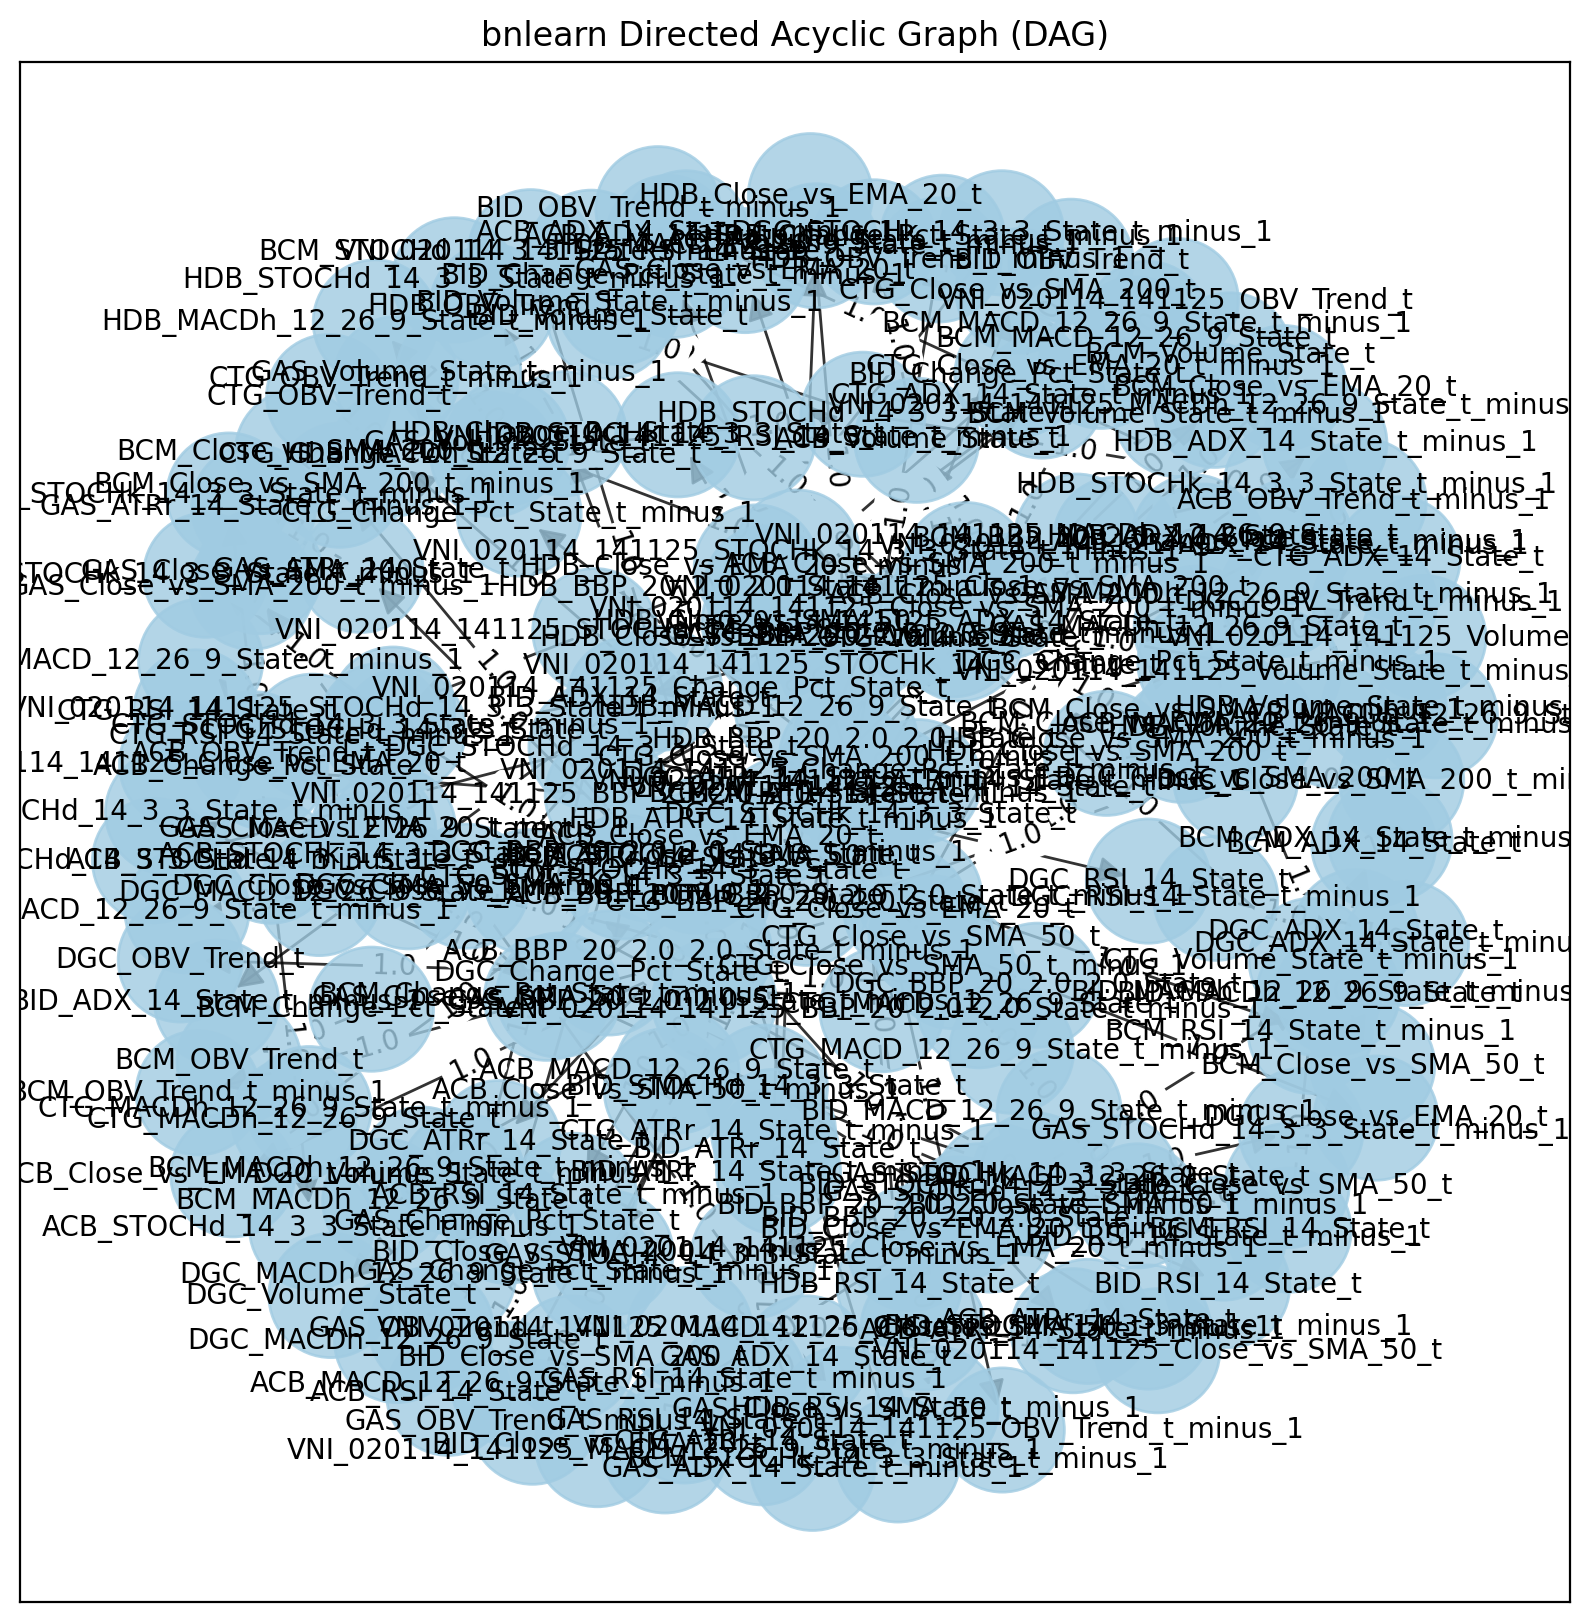


--- Starting Parameter Learning ---
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of VNI_020114_141125_STOCHd_14_3_3_State_t:
+------------------------------------------------------------------+----------+
| VNI_020114_141125_STOCHd_14_3_3_State_t(Stoch_Signal_Neutral)    | 0.421404 |
+------------------------------------------------------------------+----------+
| VNI_020114_141125_STOCHd_14_3_3_State_t(Stoch_Signal_Overbought) | 0.361292 |
+------------------------------------------------------------------+----------+
| VNI_020114_141125_STOCHd_14_3_3_State_t(Stoch_Signal_Oversold)   | 0.217304 |
+------------------------------------------------------------------+----------+
[bnlearn] >CPD of VNI_020114_141125_STOCHk_14_3_3_State_t_minus_1:
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
| ... |
+-----+
[bnlearn] >

In [ ]:
# ==============================================================================
# --- FINAL TRAINING PIPELINE: BNLEARN WITH UNCONSTRAINED LEARNING ---
# ==============================================================================

if 'train_data_final' in locals():
    print("\n--- Starting Unconstrained Structure Learning on lagged data ---")

    try:
        # Learn the structure WITHOUT any blacklist.
        # Let the algorithm find the statistically strongest connections.
        print("[bnlearn] > Computing best DAG using [chow-liu]...")
        model_edges = bn.structure_learning.fit(train_data_final, methodtype='cl')

        print("\n✅ Structure learning complete!")

        # --- Check for illogical edges (from t to t-1) ---
        nodes_t = [col for col in train_data_final.columns if col.endswith('_t')]
        nodes_t_minus_1 = [col for col in train_data_final.columns if col.endswith('_t-1')]
        illogical_edges = []
        for u, v in model_edges['model_edges']:
            if u in nodes_t and v in nodes_t_minus_1:
                illogical_edges.append((u, v))

        if illogical_edges:
            print("\nWARNING: Found illogical edges pointing from the present (t) to the past (t-1):")
            for u, v in illogical_edges:
                print(f"  - {u} -> {v}")
            print("These are likely due to statistical noise. The model is still usable.")
        else:
            print("\nINFO: No illogical edges (t -> t-1) were found. The learned structure is causally consistent.")

        # Plot the learned structure
        bn.plot(model_edges, node_size=2000, node_color='#A0CBE2')

        # --- Parameter Learning ---
        print("\n--- Starting Parameter Learning ---")
        bn_trained_model_final = bn.parameter_learning.fit(model_edges, train_data_final, methodtype='bayes')

        print("\n✅ SUCCESS: Model has been trained successfully!")

        # --- Inspect a CPT ---
        print("\n--- Inspecting a sample CPT ---")
        target_var = [col for col in train_data_final.columns if 'Change_Pct_State_t' in col][0]

        print(bn_trained_model_final['model'].get_cpds(target_var))

    except Exception as e:
        print(f"\n❌ An error occurred during bnlearn training: {e}")
else:
    print("\n'train_data_final' not found.")

--- Evaluating model performance on the test set ---

Making predictions for the target variable: 'ACB_Change_Pct_State_t_minus_1'...
[bnlearn]> Remaining columns for inference: 111


100%|██████████| 285/285 [00:34<00:00,  8.35it/s]


Predictions complete.

--- Classification Report ---
              precision    recall  f1-score   support

        Down       0.45      0.93      0.60        41
    Sideways       0.77      0.59      0.67       160
 Strong_Down       0.62      0.44      0.52        18
   Strong_Up       0.20      0.16      0.18        19
          Up       0.51      0.53      0.52        49

    accuracy                           0.59       287
   macro avg       0.51      0.53      0.50       287
weighted avg       0.63      0.59      0.59       287


--- Confusion Matrix ---


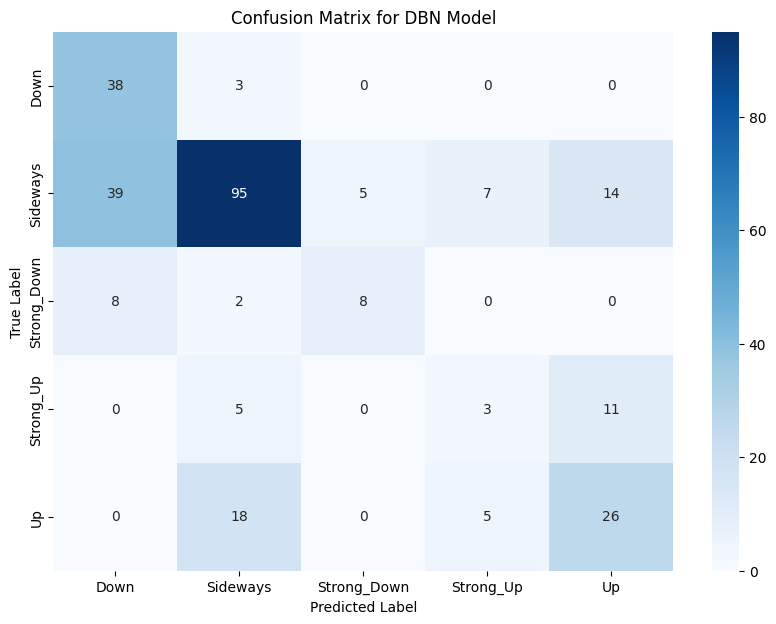

In [ ]:
# ==============================================================================
# --- STEP 7: EVALUATE THE TRAINED DBN MODEL ON THE TEST SET ---
# ==============================================================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if 'bn_trained_model_final' in locals() and 'test_data_final' in locals():
    print("--- Evaluating model performance on the test set ---")

    # 1. Prepare the test data
    # The 'evidence' is what we know (all data from t-1)
    # The 'target' is what we want to predict (the Price_Move at time t)

    target_variable = [col for col in test_data_final.columns if 'Change_Pct_State_t' in col][0]

    # Evidence variables are all columns from the previous time step (t-1)
    evidence_variables = [col for col in test_data_final.columns if '_t_minus_1' in col]

    # Create the evidence dataframe from the test set
    X_test = test_data_final[evidence_variables]

    # The true labels are in the target variable column for time t
    y_test_true = test_data_final[target_variable]

    # 2. Make predictions
    print(f"\nMaking predictions for the target variable: '{target_variable}'...")

    # Use the bn.predict() function. It takes the trained model and the evidence.
    y_test_pred = bn.predict(bn_trained_model_final, X_test, variables=[target_variable])

    # The output is a dataframe, we just need the values from the target column
    y_test_pred_labels = y_test_pred[target_variable].values

    print("Predictions complete.")

    # 3. Calculate and display performance metrics
    print("\n--- Classification Report ---")
    # This report shows Precision, Recall, and F1-Score for each class
    report = classification_report(y_test_true, y_test_pred_labels, zero_division=0)
    print(report)

    # 4. Visualize the Confusion Matrix
    print("\n--- Confusion Matrix ---")
    labels = sorted(list(set(y_test_true))) # Get the unique class labels

    cm = confusion_matrix(y_test_true, y_test_pred_labels, labels=labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for DBN Model')
    plt.show()

else:
    print("\nERROR: Trained model or test data not found. Please run the previous cells first.")

In [ ]:
# ==============================================================================
# --- STEP 8: DISPLAY ACCURACY SCORE SEPARATELY ---
# ==============================================================================
from sklearn.metrics import accuracy_score

if 'y_test_true' in locals() and 'y_test_pred_labels' in locals():
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test_true, y_test_pred_labels)

    # Print the result formatted as a percentage
    print("\n--- Model Overall Accuracy ---")
    print(f"The overall accuracy of the DBN model on the test set is: {accuracy:.2%}")
    print(f"(This means the model correctly predicted the price movement state for {accuracy:.2%} of the days in the test period.)")
else:
    print("\nCould not calculate accuracy. Please ensure the evaluation cell (Cell 7) has been run.")


--- Model Overall Accuracy ---
The overall accuracy of the DBN model on the test set is: 59.23%
(This means the model correctly predicted the price movement state for 59.23% of the days in the test period.)


--- Preparing data for Scikit-learn models ---
  > Using 111 features from time 't-1' for prediction.
  > Target variable to predict: 'ACB_Change_Pct_State_t_minus_1'

--- Encoding categorical features using One-Hot Encoding ---
Encoding complete.
  > Number of features after encoding: 310

--- Training Random Forest Classifier ---
Training complete.

--- Evaluating Random Forest model on the test set ---

--- Random Forest - Overall Accuracy ---
The overall accuracy of the Random Forest model is: 67.60%

--- Random Forest - Classification Report ---
              precision    recall  f1-score   support

        Down       0.54      0.61      0.57        41
    Sideways       0.77      0.78      0.78       160
 Strong_Down       1.00      0.56      0.71        18
   Strong_Up       0.45      0.74      0.56        19
          Up       0.53      0.41      0.46        49

    accuracy                           0.68       287
   macro avg       0.66      0.62      0.62       287
weighted 

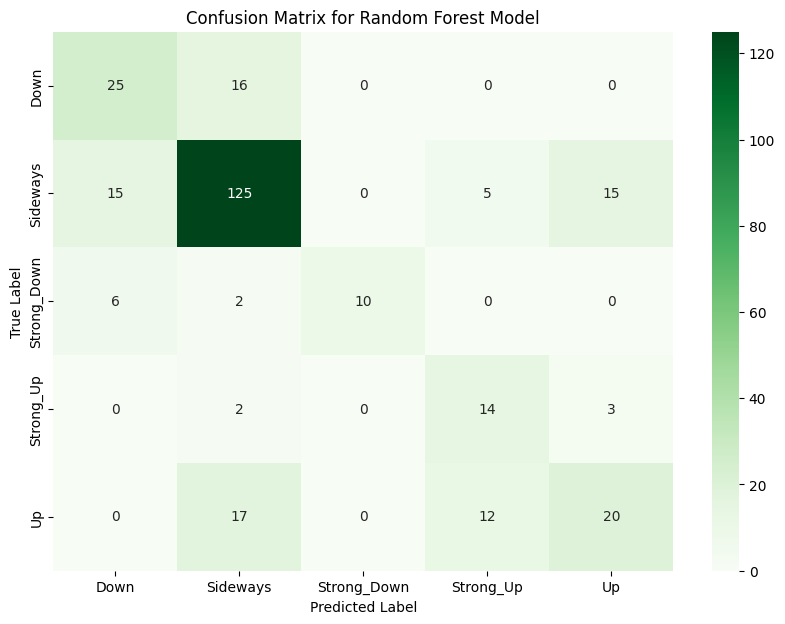

In [ ]:
# ==============================================================================
# --- PHASE 6: BASELINE MODEL - RANDOM FOREST CLASSIFIER ---
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check if the required dataframes from the DBN training process exist
if 'train_data_final' in locals() and 'test_data_final' in locals():
    print("--- Preparing data for Scikit-learn models ---")

    # 1. Identify Feature (X) and Target (y) columns
    # The target is the state of the price change at time 't'.
    target_col = [col for col in train_data_final.columns if 'Change_Pct_State_t' in col][0]

    # The features are ALL variables from the previous time step ('t-1').
    # We exclude the lagged target variable to prevent data leakage.
    lagged_target_col = [col for col in train_data_final.columns if 'Change_Pct_State_t_minus_1' in col][0]
    feature_cols = [col for col in train_data_final.columns if col.endswith('_t_minus_1') and col != lagged_target_col]

    # 2. Separate features and target for both train and test sets
    X_train_rf = train_data_final[feature_cols]
    y_train_rf = train_data_final[target_col]

    X_test_rf = test_data_final[feature_cols]
    y_test_rf_true = test_data_final[target_col]

    print(f"  > Using {len(feature_cols)} features from time 't-1' for prediction.")
    print(f"  > Target variable to predict: '{target_col}'")

    # 3. Encode Categorical Data into Numerical Format (One-Hot Encoding)
    # Scikit-learn models require numerical input.
    print("\n--- Encoding categorical features using One-Hot Encoding ---")

    X_train_encoded = pd.get_dummies(X_train_rf)
    X_test_encoded = pd.get_dummies(X_test_rf)

    # Align columns to ensure both train and test sets have the exact same features
    train_cols, test_cols = X_train_encoded.columns, X_test_encoded.columns
    missing_in_test = set(train_cols) - set(test_cols)
    for c in missing_in_test:
        X_test_encoded[c] = 0
    missing_in_train = set(test_cols) - set(train_cols)
    for c in missing_in_train:
        X_train_encoded[c] = 0

    X_test_encoded = X_test_encoded[train_cols] # Ensure same column order

    print("Encoding complete.")
    print(f"  > Number of features after encoding: {X_train_encoded.shape[1]}")

    # ==============================================================================
    # --- RANDOM FOREST MODEL TRAINING AND EVALUATION ---
    # ==============================================================================
    print("\n--- Training Random Forest Classifier ---")

    # Initialize the model
    rf_model = RandomForestClassifier(
        n_estimators=100,     # A good starting number of trees
        random_state=42,      # Ensures results are reproducible
        n_jobs=-1             # Uses all available CPU cores for faster training
    )

    # Train the model on the encoded training data
    rf_model.fit(X_train_encoded, y_train_rf)

    print("Training complete.")

    # --- Make Predictions and Evaluate on the Test Set ---
    print("\n--- Evaluating Random Forest model on the test set ---")
    y_test_rf_pred = rf_model.predict(X_test_encoded)

    # --- Display Results ---
    rf_accuracy = accuracy_score(y_test_rf_true, y_test_rf_pred)

    print("\n--- Random Forest - Overall Accuracy ---")
    print(f"The overall accuracy of the Random Forest model is: {rf_accuracy:.2%}")

    print("\n--- Random Forest - Classification Report ---")
    rf_report = classification_report(y_test_rf_true, y_test_rf_pred, zero_division=0)
    print(rf_report)

    print("\n--- Random Forest - Confusion Matrix ---")
    rf_labels = sorted(list(set(y_test_rf_true)))
    rf_cm = confusion_matrix(y_test_rf_true, y_test_rf_pred, labels=rf_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', xticklabels=rf_labels, yticklabels=rf_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Random Forest Model')
    plt.show()

else:
    print("\nERROR: 'train_data_final' and 'test_data_final' not found. Please run the data preparation and splitting cells first.")